In [125]:
import numpy as np
import matplotlib.pyplot as plt

In [126]:
# region of interest will involve points in a circle
N = 10000
R = 1

# datapoints
x = 10 * np.random.random(N) - 5
y = 10 * np.random.random(N) - 5

# central region of interest
t = np.linspace(0,2*np.pi,1000)
x_circle = np.cos(t)
y_circle = np.sin(t)

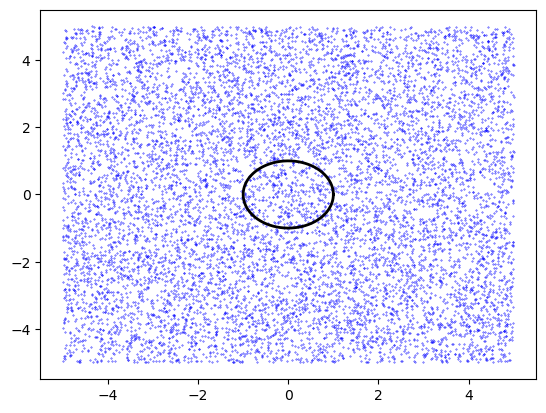

In [127]:
plt.scatter(x,y,c = 'b', s = 0.1)
plt.plot(x_circle, y_circle, c = 'k', lw = 2)

In [128]:
from matplotlib.path import Path

edge_points = np.stack((x_circle, y_circle), axis = -1) 
edge_tuples = [tuple(edge_points[n,:]) for n in range(len(edge_points))]

points = np.stack((x, y), axis = -1) 
tuples = [tuple(points[n,:]) for n in range(len(points))]
        
p = Path(edge_tuples) # make a polygon
grid = p.contains_points(points)

x_grid = x[grid]
y_grid = y[grid]

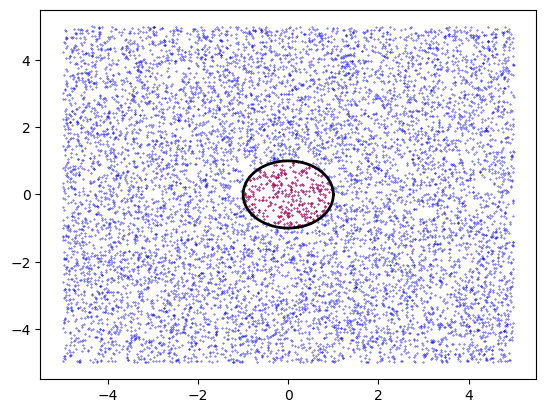

In [129]:
plt.scatter(x,y,c = 'b', s = 0.1)
plt.plot(x_circle, y_circle, c = 'k', lw = 2)
plt.scatter(x_grid, y_grid, c = 'r', s = 0.1)

In [130]:
edge_points.shape

(1000, 2)

In [131]:
# hybrid approach: include points inside the father pixel, points up to some reasonable distance, 
# and points that are near the edges

from astropy.coordinates import angular_separation

N_edge_points = len(x_circle)
dist_scale = 1

for n in range(N_edge_points):
    edge_point = edge_points[n,:]
    buf_edge_point = edge_point[np.newaxis, :]
    relative_positions = buf_edge_point - points
    distances = np.linalg.norm(relative_positions, axis = -1)
    x_out = x[distances < dist_scale]
    y_out = y[distances < dist_scale]
    if n == 0:
        points_out = np.stack((x_out, y_out), axis = -1)
    else:
        points_out = np.concatenate((points_out, np.stack((x_out, y_out), axis = -1)))
    
# distances = angular_separation(lon[2::2], lat[2::2], lon[1::2], lat[1::2])

In [132]:
print(points_out)
print(len(points_out))

_, unique_indices = np.unique(points_out, axis = 0, return_index = True)
x_out = points_out[unique_indices,0]
y_out = points_out[unique_indices,1]

print(len(x_out))

[[ 1.3024472   0.12206287]
 [ 0.79615009 -0.47194942]
 [ 1.51154793 -0.43310038]
 ...
 [ 0.40405329 -0.57055284]
 [ 1.4575023   0.3403669 ]
 [ 1.15125858 -0.95352335]]
311565
1241


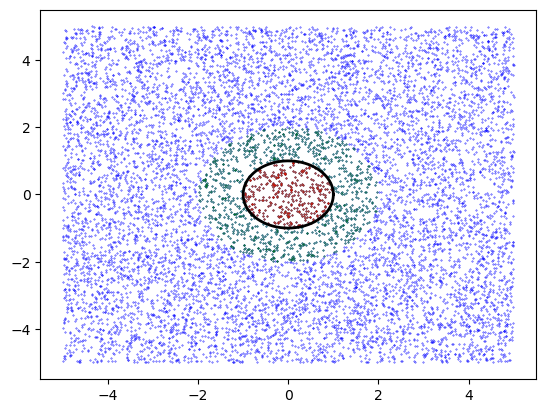

In [133]:
plt.scatter(x,y,c = 'b', s = 0.1)
plt.plot(x_circle, y_circle, c = 'k', lw = 2)
plt.scatter(x_out, y_out, c = 'g', s = 0.1)
plt.scatter(x_grid, y_grid, c = 'r', s = 0.1)

In [134]:
from scipy.spatial import Delaunay
import numpy as np


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [135]:
points_out_unique = np.stack((x_out, y_out), axis = -1)

In [136]:
extension_edges = alpha_shape(points = points_out_unique, alpha =1, only_outer = True)

/tmp/ipykernel_268/124789751.py:1: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  extension_edges = alpha_shape(points = points_out_unique, alpha =1, only_outer = True)


In [137]:
print(extension_edges)

{(741, 769), (917, 894), (1122, 1153), (15, 32), (108, 50), (277, 398), (1149, 1107), (137, 108), (34, 18), (155, 137), (1159, 1149), (260, 155), (153, 166), (504, 646), (593, 385), (32, 70), (646, 741), (86, 153), (2, 1), (1240, 1238), (1225, 1237), (801, 757), (455, 504), (385, 295), (634, 593), (295, 260), (1107, 1074), (50, 43), (6, 2), (1239, 1240), (398, 455), (1074, 1046), (208, 221), (1153, 1184), (1234, 1239), (43, 34), (894, 801), (166, 208), (769, 794), (70, 86), (1046, 917), (757, 634), (1238, 1224), (1, 0), (8, 15), (1019, 1035), (1224, 1159), (1237, 1234), (0, 8), (1184, 1225), (943, 1019), (221, 277), (18, 6), (1035, 1122), (794, 943)}


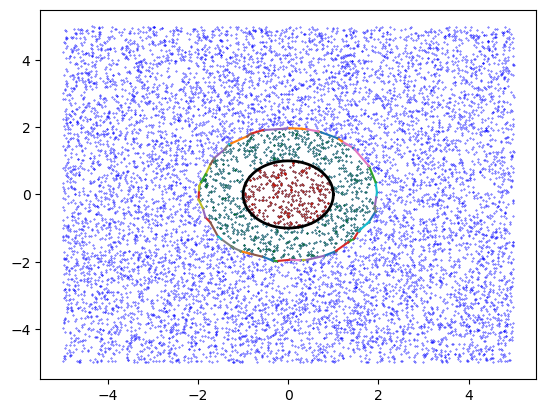

In [138]:
plt.scatter(x,y,c = 'b', s = 0.1)
plt.plot(x_circle, y_circle, c = 'k', lw = 2)
plt.scatter(x_out, y_out, c = 'g', s = 0.1)
plt.scatter(x_grid, y_grid, c = 'r', s = 0.1)
for i,j in extension_edges:
    plt.plot(points_out_unique[[i,j],0], points_out_unique[[i,j],1])

In [139]:
# stitch edges
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

In [140]:
ext_edge = stitch_boundaries(extension_edges)[0]

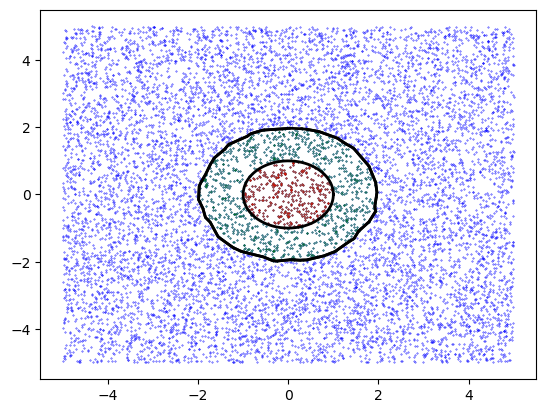

In [141]:
plt.scatter(x,y,c = 'b', s = 0.1)
plt.plot(x_circle, y_circle, c = 'k', lw = 2)
plt.scatter(x_out, y_out, c = 'g', s = 0.1)
plt.scatter(x_grid, y_grid, c = 'r', s = 0.1)
plt.plot(points_out_unique[ext_edge,0], points_out_unique[ext_edge,1], c = 'k', lw = 2)

In [142]:
print(points_out_unique[ext_edge,:][:,0,:])
print(points_out_unique[ext_edge,:])

[[ 0.29942451  1.95577422]
 [ 0.02669026  1.97062384]
 [-0.07502849  1.95814371]
 [-0.56049668  1.91552053]
 [-0.82986909  1.80879722]
 [-0.91416848  1.72871931]
 [-1.26391981  1.52026352]
 [-1.31624194  1.49710326]
 [-1.41339209  1.34217471]
 [-1.64250266  1.0836121 ]
 [-1.67947454  0.99629047]
 [-1.72441107  0.90131537]
 [-1.83042933  0.60433966]
 [-1.93267972  0.36789704]
 [-1.9735051   0.25179353]
 [-1.98054801  0.06210984]
 [-1.98901534 -0.15222113]
 [-1.89639384 -0.40304231]
 [-1.83521125 -0.68391029]
 [-1.73040523 -0.82568035]
 [-1.55765223 -1.2505585 ]
 [-1.49291069 -1.32055886]
 [-1.26412009 -1.54252316]
 [-1.22165751 -1.58038128]
 [-1.06455434 -1.67992203]
 [-1.01114296 -1.70401305]
 [-0.8646558  -1.75574815]
 [-0.54342549 -1.86078132]
 [-0.34788204 -1.96848722]
 [-0.26038212 -1.98142154]
 [ 0.05766644 -1.94162365]
 [ 0.26269845 -1.95691102]
 [ 0.32844705 -1.95067033]
 [ 0.40485383 -1.94880512]
 [ 0.78890027 -1.82717829]
 [ 1.02450451 -1.70490617]
 [ 1.06191935 -1.67473364]
 

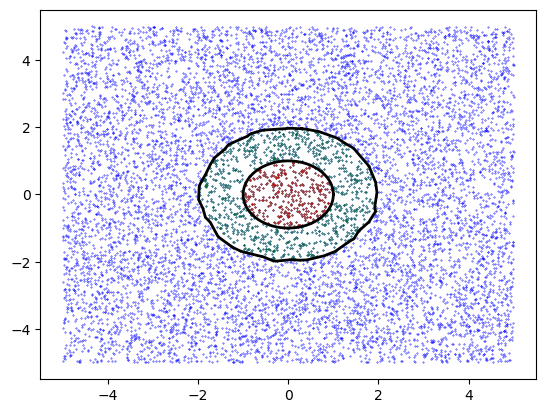

In [149]:
boundary_points = points_out_unique[ext_edge,:][:,0,:]
boundary_points = np.append(boundary_points, [boundary_points[0,:]], axis = 0)
x_out_circle = boundary_points[:,0] ; y_out_circle = boundary_points[:,1]

plt.scatter(x,y,c = 'b', s = 0.1)
plt.plot(x_circle, y_circle, c = 'k', lw = 2)
plt.scatter(x_out, y_out, c = 'g', s = 0.1)
plt.scatter(x_grid, y_grid, c = 'r', s = 0.1)
plt.plot(x_out_circle, y_out_circle, c = 'k', lw = 2)

In [150]:
# hybrid approach: include points inside the father pixel, points up to some reasonable distance, 
# and points that are near the boundarys

from astropy.coordinates import angular_separation

N_boundary_points = len(x_out_circle)
dist_scale = 1

for n in range(N_boundary_points):
    boundary_point = boundary_points[n,:]
    buf_boundary_point = boundary_point[np.newaxis, :]
    relative_positions = buf_boundary_point - points
    distances = np.linalg.norm(relative_positions, axis = -1)
    x_out_out = x[distances < dist_scale]
    y_out_out= y[distances < dist_scale]
    if n == 0:
        points_out_out = np.stack((x_out_out, y_out_out), axis = -1)
    else:
        points_out_out = np.concatenate((points_out_out, np.stack((x_out_out, y_out_out), axis = -1)))
    
# distances = angular_separation(lon[2::2], lat[2::2], lon[1::2], lat[1::2])

In [151]:
print(points_out)
print(len(points_out))

_, unique_indices = np.unique(points_out_out, axis = 0, return_index = True)
x_out_out = points_out_out[unique_indices,0]
y_out_out = points_out_out[unique_indices,1]

print(len(x_out))

[[ 1.3024472   0.12206287]
 [ 0.79615009 -0.47194942]
 [ 1.51154793 -0.43310038]
 ...
 [ 0.40405329 -0.57055284]
 [ 1.4575023   0.3403669 ]
 [ 1.15125858 -0.95352335]]
311565
1241


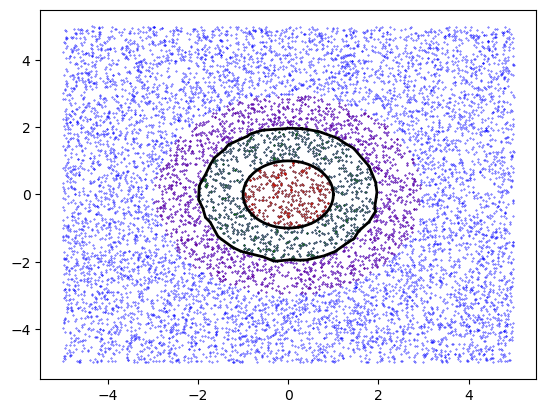

In [152]:
plt.scatter(x,y,c = 'b', s = 0.1)
plt.plot(x_circle, y_circle, c = 'k', lw = 2)
plt.scatter(x_out_out, y_out_out, c = 'purple', s = 0.1)
plt.scatter(x_out, y_out, c = 'g', s = 0.1)
plt.scatter(x_grid, y_grid, c = 'r', s = 0.1)
plt.plot(x_out_circle, y_out_circle, c = 'k', lw = 2)